In [1]:
from pathlib import Path
import sys
root = Path.cwd().parent
sys.path.append(str(root))

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import pytest
from tqdm import tqdm
from dbca.datasets.relational import make_generated_story, RelationalSample
from dbca.sample_set import SampleSet
from dbca.dist_funcs import chernoff_divergence
from dbca.freq_distribution import FrequencyDistribution
from dbca.dbca_splitter import DBCASplitter, DBCASplitterConfig

from dbca.datasets.relational.utils import get_samples

atoms (5):  ['3', '+', '3', '/', '1']
compounds (9):  [/_+, +_3, /_1, /_+_3, /_+_1, +_3_3, /_+_3_3, /_+_3_1, /_+_3_3_1]


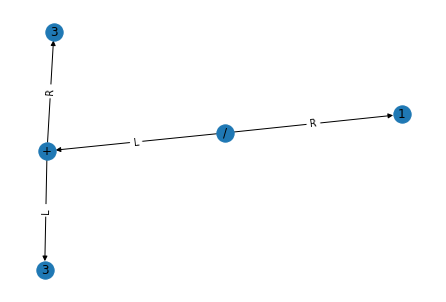

In [2]:
from dbca.datasets.relational import RelationalSample
def sample2graph(expr, heads):
    g = nx.DiGraph()
    g.add_nodes_from([(i, {'sym': x}) for i, x in enumerate(expr) if x not in '()'])
    for i, h in enumerate(heads):
        if h == -1 or expr[i] in '()':
            continue
        direction = 'L' if i < h else 'R'
        g.add_edge(h, i, dir=direction)
    return g

# expr = '1/(4+3)'
# heads = [1, -1, 4, 4, 1, 4, 4]

expr = '(3+3)/1'
heads = [2, 2, 5, 2, 2, -1, 5]

# expr = '3-4'
# heads = [1, -1, 1]

g = sample2graph(expr, heads)

pos = nx.spring_layout(g)
nx.draw(g, pos)
node_labels = nx.get_node_attributes(g,'sym')
nx.draw_networkx_labels(g, pos, labels = node_labels)
edge_labels = nx.get_edge_attributes(g,'dir')
nx.draw_networkx_edge_labels(g, pos, edge_labels)

sample = RelationalSample(g, name='test')
print(f'atoms ({len(sample.atoms)}): ', sorted(sample.atoms, key=lambda x: len(str(x))))
print(f'compounds ({len(sample.compounds)}): ', sorted(sample.compounds, key=lambda x: len(str(x))))

In [16]:
nx.get_node_attributes(g, 'sym').values()

dict_values(['3', '+', '3', '/', '1'])

So what do splits look like for various compound divergence settings? We'll start with a toy setting over small splits.

In [2]:
SAMPLE_POOL_SIZE = 1000


samples = get_samples(num_samples=SAMPLE_POOL_SIZE, seed=12345, num_entities=10, num_edges=5, fixed_scale=False)



100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 909.79it/s]


DiGraph with 7 nodes and 5 edges s_0_KQmWLa4oLGSzVZGMKAnfYG {e3_e1, e5_e0, e2_e7, e5_e8, e5_e3_e1, e5_e3}


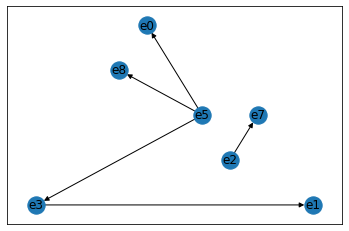

In [63]:
s = samples[0]
s.visualize()
print(s.G, s.id, s.compounds)

In [3]:
cfg_1 = DBCASplitterConfig(d_a=0.02, d_c=1.0, pool_size=SAMPLE_POOL_SIZE, n_train=50, n_test=50, save_dir="test_reg", verbose=False)
spg = DBCASplitter(samples, cfg_1)
spg.generate_splits()


INFO:dbca.storage:Loading samples into storage...
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1050.49it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 1000 samples...
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 12209.71it/s]
INFO:dbca.full_sample_set:Computing weight for all 945 compounds...
100%|███████████████████████████████████████| 945/945 [00:00<00:00, 1948.51it/s]
INFO:dbca.full_sample_set:Keeping 945/945 highest weighted compounds.
INFO:dbca.dbca_splitter:Creating output directory at test_reg...
INFO:dbca.dbca_splitter:Choosing random first sample: s_436_5MH5hJ8qWKcb8SAiFcbVDn...
INFO:dbca.dbca_splitter:Starting to create splits...
100%|███████████████████████████████████████████| 99/99 [00:26<00:00,  3.78it/s]
INFO:dbca.dbca_splitter:Finished creating dataset!
INFO:dbca.dbca_splitter:Train set size: 50, test set size: 50
INFO:dbca.dbca_splitter:D_A: 0.010327269461981814, D_C: 0.9657044792983216
INFO:dbca.dbca_splitte

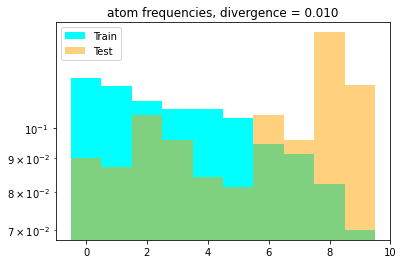

<module 'matplotlib.pyplot' from '/home/qing/.virtualenvs/hint/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [4]:
spg.visualize_dists('atom')

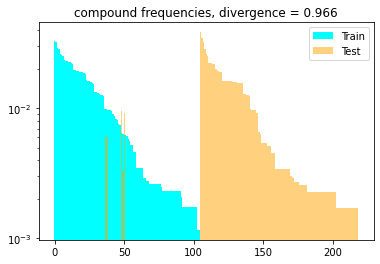

<module 'matplotlib.pyplot' from '/home/qing/.virtualenvs/hint/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [5]:
spg.visualize_dists('compound')

In [6]:
D_C = 0.75
cfg_2 = DBCASplitterConfig(d_a=0.02, d_c=D_C, pool_size=SAMPLE_POOL_SIZE, n_train=50, n_test=50, save_dir=f"test_reg_{D_C}")
spg = DBCASplitter(samples, cfg_2)
spg.generate_splits()

INFO:dbca.config:Setting logging level to 20
INFO:dbca.storage:Loading samples into storage...
100%|██████████| 1000/1000 [00:00<00:00, 15305.67it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 1000 samples...
100%|██████████| 1000/1000 [00:00<00:00, 14312.83it/s]
INFO:dbca.full_sample_set:Computing weight for all 945 compounds...
100%|██████████| 945/945 [00:01<00:00, 577.31it/s]
INFO:dbca.full_sample_set:Keeping 945/945 highest weighted compounds.
INFO:dbca.dbca_splitter:Creating output directory at test_reg_0.75...
INFO:dbca.dbca_splitter:Choosing random first sample: s_942_YFWoRWcSovmYKq3XZe2c4C...
INFO:dbca.dbca_splitter:Starting to create splits...
100%|██████████| 99/99 [00:47<00:00,  2.09it/s]
INFO:dbca.dbca_splitter:Finished creating dataset!
INFO:dbca.dbca_splitter:Train set size: 50, test set size: 50
INFO:dbca.dbca_splitter:D_A: 0.006948174409679098, D_C: 0.7499391979313477
INFO:dbca.dbca_splitter:Saving to test_reg_0.75...
INFO:dbca.dbca_splitter:Done!


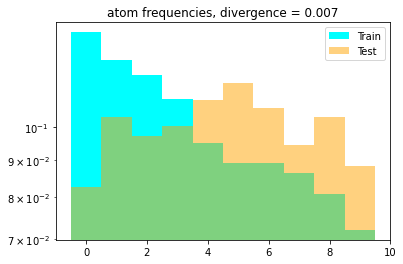

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [7]:
spg.visualize_dists('atom')

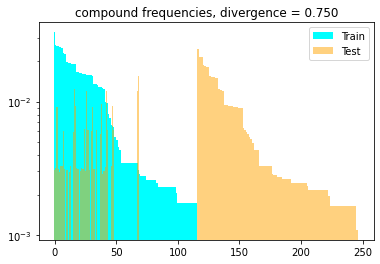

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [8]:
spg.visualize_dists('compound')

In [9]:
D_C = 0.50
cfg_2 = DBCASplitterConfig(d_a=0.02, d_c=D_C, pool_size=SAMPLE_POOL_SIZE, n_train=50, n_test=50, save_dir=f"test_reg_{D_C}")
spg = DBCASplitter(samples, cfg_2)
spg.generate_splits()

INFO:dbca.config:Setting logging level to 20
INFO:dbca.storage:Loading samples into storage...
100%|██████████| 1000/1000 [00:00<00:00, 2442.59it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 1000 samples...
100%|██████████| 1000/1000 [00:00<00:00, 25726.56it/s]
INFO:dbca.full_sample_set:Computing weight for all 945 compounds...
100%|██████████| 945/945 [00:01<00:00, 574.81it/s]
INFO:dbca.full_sample_set:Keeping 945/945 highest weighted compounds.
INFO:dbca.dbca_splitter:Creating output directory at test_reg_0.5...
INFO:dbca.dbca_splitter:Choosing random first sample: s_942_YFWoRWcSovmYKq3XZe2c4C...
INFO:dbca.dbca_splitter:Starting to create splits...
100%|██████████| 99/99 [00:48<00:00,  2.06it/s]
INFO:dbca.dbca_splitter:Finished creating dataset!
INFO:dbca.dbca_splitter:Train set size: 50, test set size: 50
INFO:dbca.dbca_splitter:D_A: 0.0029161465607272508, D_C: 0.49999348033114865
INFO:dbca.dbca_splitter:Saving to test_reg_0.5...
INFO:dbca.dbca_splitter:Done!


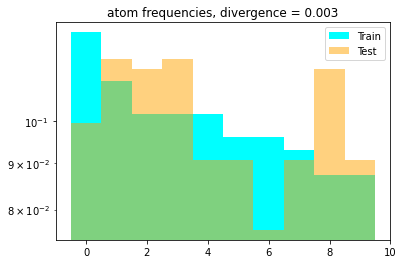

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [10]:
spg.visualize_dists('atom')

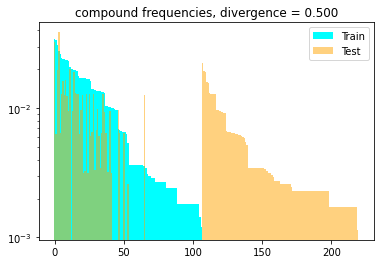

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [11]:
spg.visualize_dists('compound')

In [12]:
D_C = 0.25
cfg_2 = DBCASplitterConfig(d_a=0.02, d_c=D_C, pool_size=SAMPLE_POOL_SIZE, n_train=50, n_test=50, save_dir=f"test_reg_{D_C}", verbose=True)
spg = DBCASplitter(samples, cfg_2)
spg.generate_splits()

INFO:dbca.config:Setting logging level to 10
INFO:dbca.storage:Loading samples into storage...
100%|██████████| 1000/1000 [00:00<00:00, 40179.17it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 1000 samples...
100%|██████████| 1000/1000 [00:00<00:00, 42676.22it/s]
INFO:dbca.full_sample_set:Computing weight for all 945 compounds...
100%|██████████| 945/945 [00:01<00:00, 649.77it/s]
INFO:dbca.full_sample_set:Keeping 945/945 highest weighted compounds.
INFO:dbca.dbca_splitter:Creating output directory at test_reg_0.25...
INFO:dbca.dbca_splitter:Choosing random first sample: s_942_YFWoRWcSovmYKq3XZe2c4C...
INFO:dbca.dbca_splitter:Starting to create splits...
100%|██████████| 99/99 [00:40<00:00,  2.43it/s]
INFO:dbca.dbca_splitter:Finished creating dataset!
INFO:dbca.dbca_splitter:Train set size: 50, test set size: 50
INFO:dbca.dbca_splitter:D_A: 0.0012673632398068069, D_C: 0.2499119802358074
INFO:dbca.dbca_splitter:Saving to test_reg_0.25...
INFO:dbca.dbca_splitter:Done!


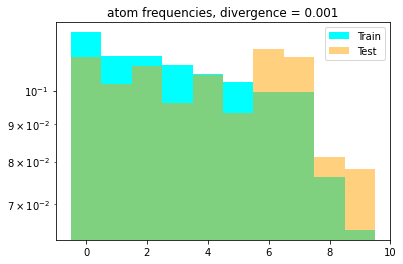

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [13]:
spg.visualize_dists('atom')

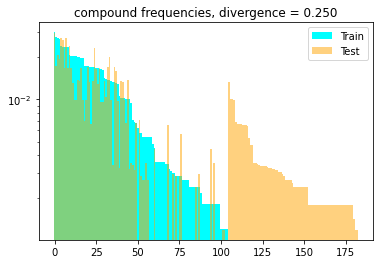

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [14]:
spg.visualize_dists('compound')

In [15]:
D_C = 0.1
cfg_2 = DBCASplitterConfig(d_a=0.02, d_c=D_C, pool_size=SAMPLE_POOL_SIZE, n_train=50, n_test=50, save_dir=f"test_reg_{D_C}", verbose=False)
spg = DBCASplitter(samples, cfg_2)
spg.generate_splits()

INFO:dbca.config:Setting logging level to 20
INFO:dbca.storage:Loading samples into storage...
100%|██████████| 1000/1000 [00:00<00:00, 8929.75it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 1000 samples...
100%|██████████| 1000/1000 [00:00<00:00, 10793.95it/s]
INFO:dbca.full_sample_set:Computing weight for all 945 compounds...
100%|██████████| 945/945 [00:01<00:00, 554.68it/s]
INFO:dbca.full_sample_set:Keeping 945/945 highest weighted compounds.
INFO:dbca.dbca_splitter:Creating output directory at test_reg_0.1...
INFO:dbca.dbca_splitter:Choosing random first sample: s_942_YFWoRWcSovmYKq3XZe2c4C...
INFO:dbca.dbca_splitter:Starting to create splits...
100%|██████████| 99/99 [01:01<00:00,  1.62it/s]
INFO:dbca.dbca_splitter:Finished creating dataset!
INFO:dbca.dbca_splitter:Train set size: 50, test set size: 50
INFO:dbca.dbca_splitter:D_A: 0.00043044248944279495, D_C: 0.10000674330533965
INFO:dbca.dbca_splitter:Saving to test_reg_0.1...
INFO:dbca.dbca_splitter:Done!


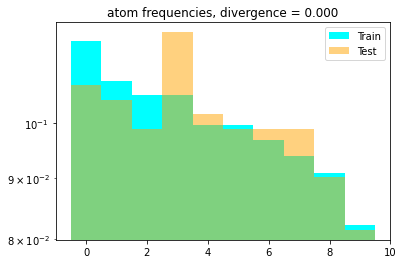

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [16]:
spg.visualize_dists('atom')

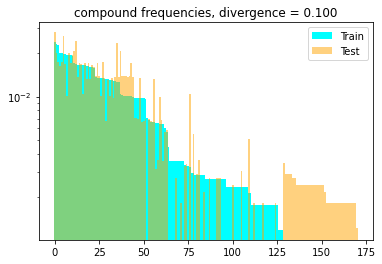

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [17]:
spg.visualize_dists('compound')

In [18]:
D_C = 0.02
cfg_2 = DBCASplitterConfig(d_a=0.02, d_c=D_C, pool_size=SAMPLE_POOL_SIZE, n_train=50, n_test=50, save_dir=f"test_reg_{D_C}", verbose=False)
spg = DBCASplitter(samples, cfg_2)
spg.generate_splits()

INFO:dbca.config:Setting logging level to 20
INFO:dbca.storage:Loading samples into storage...
100%|██████████| 1000/1000 [00:00<00:00, 13570.42it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 1000 samples...
100%|██████████| 1000/1000 [00:00<00:00, 15987.13it/s]
INFO:dbca.full_sample_set:Computing weight for all 945 compounds...
100%|██████████| 945/945 [00:01<00:00, 528.73it/s]
INFO:dbca.full_sample_set:Keeping 945/945 highest weighted compounds.
INFO:dbca.dbca_splitter:Creating output directory at test_reg_0.02...
INFO:dbca.dbca_splitter:Choosing random first sample: s_942_YFWoRWcSovmYKq3XZe2c4C...
INFO:dbca.dbca_splitter:Starting to create splits...
100%|██████████| 99/99 [00:37<00:00,  2.62it/s]
INFO:dbca.dbca_splitter:Finished creating dataset!
INFO:dbca.dbca_splitter:Train set size: 50, test set size: 50
INFO:dbca.dbca_splitter:D_A: 0.0008307959236504292, D_C: 0.01970971807428057
INFO:dbca.dbca_splitter:Saving to test_reg_0.02...
INFO:dbca.dbca_splitter:Done!


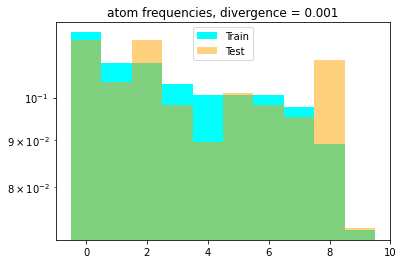

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [19]:
spg.visualize_dists('atom')

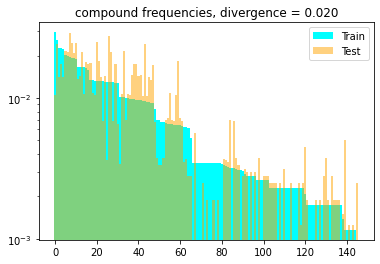

<module 'matplotlib.pyplot' from '/home/ronent/anaconda3/envs/dbca-splitter/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [20]:
spg.visualize_dists('compound')